# SPARC-4 Pipeline Tools
## Night:``2023-06-06``
## Modes: ``PHOTOMETRY`` and ``POLARIMETRY``
***

This notebook shows an example of the full reduction of the SPARC4 data  in the [minidata package](https://drive.google.com/file/d/1tAVjyhYGMDcrU5sDdGCmd_f5HoazZ294/view?usp=drive_link)  using the SPARC4 pipeline tools. 

* Author: Eder Martioli, LNA 18 Apr 2024

In [1]:
import os, sys
import sparc4.product_plots as s4plt
import sparc4.pipeline_lib as s4pipelib
import sparc4.utils as s4utils
import glob
import warnings
warnings.filterwarnings('ignore')

## User inputs and initial setup

Before starting the reduction, we must configure a few parameters. The pipeline comes with default values for all parameters. To modify these, one can create and edit their own parameter file, then load it into the ``PARAMS_FILE`` variable. Alternatively, parameters can be changed by directly resetting the dictionary entry for a specific parameter, like this: ``p['PARAM_NAME'] = PARAM_NEW_VALUE``. See examples below.

In [2]:
# set night directory name
NIGHTDIR = '20230606'
# set raw data root directory
ROOTDATADIR =  "/Users/eder/Data/SPARC4/minidata/"
# set reduced data root directory
ROOTREDUCEDDIR = "/Users/eder/Data/SPARC4/minidata/reduced/"
# set reduced data root directory
PIPELINEDIR = "/Users/eder/sparc4-pipeline/"
# define path to default calibration directory
calibdb_dir = os.path.join(PIPELINEDIR, "calibdb/")

# set path to the parameters file:
#PARAMS_FILE = ""  # to use deafult values
PARAMS_FILE = "{}/user_files/my_params.yaml".format(PIPELINEDIR)

# set path to a target list file
# this is to force targets to be included in the source catalog in addition to those detected automatically
#TARGET_LIST_FILE = os.path.join(PIPELINEDIR,"user_files/targets.csv")

# select a SPARC4 channel: 1 (g), 2 (r), 3 (i) or 4 (z)
CHANNEL = 1

# initialize pipeline parameters
p = s4pipelib.init_s4_p(NIGHTDIR,
                        ROOTDATADIR,
                        ROOTREDUCEDDIR,
                        print_report=False,
                        param_file=PARAMS_FILE)

# get data dir
datadir = p['data_directories'][CHANNEL-1]
# get reduce dir
reducedir = p['reduce_directories'][CHANNEL-1]

# to force reduction even if products already exist
FORCE = False

###############################################################
# Below are a few examples on how to manually reset parameters: 
###############################################################

# set astrometry reference image as the one for this channel
p["ASTROM_REF_IMG"] = os.path.join(calibdb_dir, p["ASTROM_REF_IMGS"][CHANNEL-1])

# to build stacks of 10 images instead of the default value of 16 images
p['NFILES_FOR_STACK'] = 10

# to change the S/N threshold for detecting sources
# -- note that lower values will result in more (fainter) sources being detected.
p['PHOT_THRESHOLD'] = 100


# Turn off flat per waveplate position, as for this dataset  
# there are only flats available for 1 flat position
p['APPLY_FLAT_PER_WPPOS'] = False

# uncomment below to print all parameters and their respective values:
#for key in p.keys():
#    print("p['{}']={}".format(key,p[key]))

***
# <font color='darkblue'>Bias and Flat-field calibrations</font> 

In this section we build the master bias and flat-field calibrations.

## Define input list and output product file names

In [3]:
# create a list of zeros for current detector mode
zero_list = glob.glob("{}/{}".format(datadir,"*zero*.fits"))

# define file name of master bias 
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(reducedir,
                                                   NIGHTDIR,
                                                   CHANNEL)

# create a list of flats for current detector mode
flat_list = glob.glob("{}/{}".format(datadir,"*dflat*.fits"))

# define file name of master flat
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(reducedir,
                                                   NIGHTDIR,
                                                   CHANNEL)

# Run master calibration

The master calibration routine combines a list of calibration files into a master calibration image.

In [4]:
# calculate master bias and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=zero_list, 
                                     output=p["master_bias"], 
                                     obstype='bias', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     force=FORCE)

In [5]:
# calculate master dome flat and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=flat_list, 
                                     output=p["master_flat"], 
                                     obstype='flat', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     normalize=True, 
                                     force=FORCE)

# Plot master calibration results

Now, we plot the results to check if they look fine. 

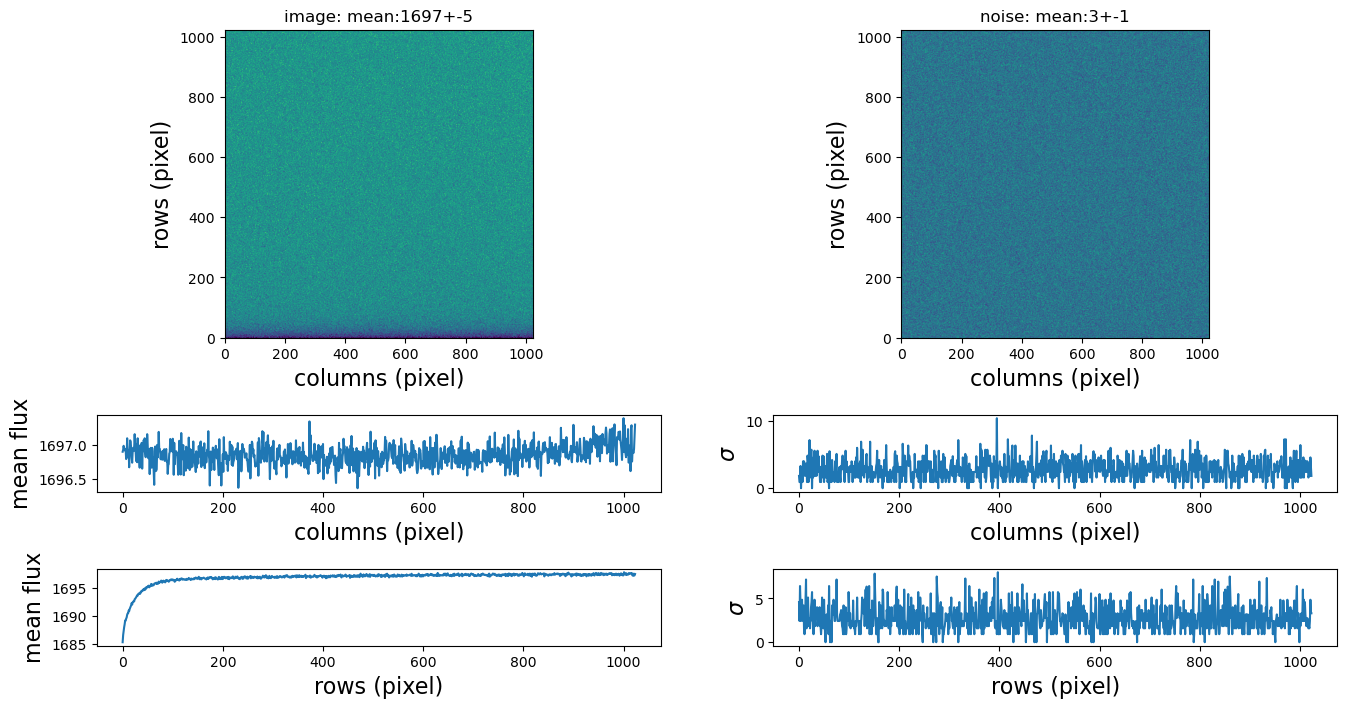

In [6]:
# plot master bias
s4plt.plot_cal_frame(p["master_bias"], 
                     percentile=99.5, 
                     combine_rows=True, 
                     combine_cols=True)

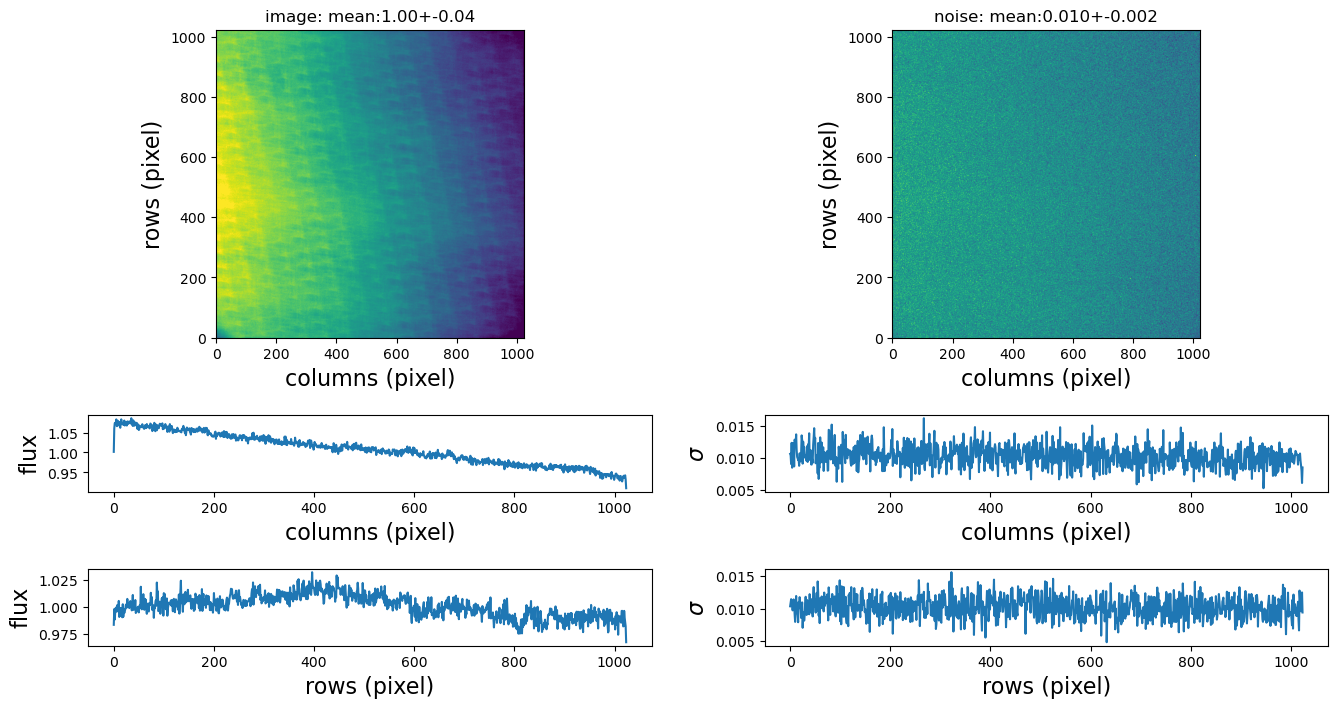

In [7]:
# plot master flat
s4plt.plot_cal_frame(p["master_flat"], 
                     percentile=99.5, 
                     xcut=512, 
                     ycut=512)

***
# <font color='darkblue'>Science image reduction</font> 

In this section we reduce the science data. In this example we show the reductiion processes for the following observations:

* The photometric standard [LTT 4816](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=ltt4816&submit=SIMBAD+search) observed in photometric mode. 
* The polarimetric standard [HD 111579](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+111579&submit=SIMBAD+search) observed in polarimetric mode.  It was observed in 16 rotating positions of the waveplate, equally spaced by 22.5 degrees, utilizing both L/2 and L/4 waveplate retarders.

## `PHOTOMETRIC` mode

### Select LTT 4816 data

In [8]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "ltt4816"  # LTT 4816 is a spectro-photometric standard

# set suffix for output stack filename
stack_suffix = "{}_s4c{}_{}".format(NIGHTDIR, 
                                    CHANNEL, 
                                    OBJECTID.replace(" ",""))
# create a list of science data 
sci_list = glob.glob("{}/{}".format(datadir,"*ltt4816.fits"))

### Reduce LTT 4816 data

To reduce scientific frames, run the routine ``s4pipelib.stack_and_reduce_sci_images``. This routine performs calibration for detector gain, bias, and flat-field. Then, a subset of frames is stacked to generate a stack product. Source detection is then conducted within the stack frame, and the identified sources are cross-referenced with a catalog to establish an astrometric solution and generate a master catalog for all input observations of this field. Aperture photometry is computed for several aperture sizes across all sources and for all input image frames. Finally, the resulting calibrated images and their associated photometric catalogs are saved into ``proc.fits`` product FITS files.

2024-09-20 11:04:18,779 root - INFO - There is already a stack image :  [pipeline_lib]


2024-09-20 11:04:18,779 | INFO | There is already a stack image :


2024-09-20 11:04:18,803 root - INFO - The 7 images will be reduced in 1 loops of 100 images each time  [pipeline_lib]


2024-09-20 11:04:18,803 | INFO | The 7 images will be reduced in 1 loops of 100 images each time


2024-09-20 11:04:18,804 root - INFO - Running loop 0 of 1 -> images in loop: 0 to 7 ...   [pipeline_lib]


2024-09-20 11:04:18,804 | INFO | Running loop 0 of 1 -> images in loop: 0 to 7 ... 


2024-09-20 11:04:18,874 root - INFO - OBJECT files: 8  [pipeline_lib]


2024-09-20 11:04:18,874 | INFO | OBJECT files: 8


2024-09-20 11:04:18,875 root - INFO - Creating output list of processed science frames ...   [pipeline_lib]


2024-09-20 11:04:18,875 | INFO | Creating output list of processed science frames ... 


2024-09-20 11:04:18,876 root - INFO - 1 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000012_ltt4816_proc.fits  [pipeline_lib]


2024-09-20 11:04:18,876 | INFO | 1 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000012_ltt4816_proc.fits


2024-09-20 11:04:18,876 root - INFO - 2 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000012_ltt4816_proc.fits  [pipeline_lib]


2024-09-20 11:04:18,876 | INFO | 2 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000012_ltt4816_proc.fits


2024-09-20 11:04:18,877 root - INFO - 3 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000015_ltt4816_proc.fits  [pipeline_lib]


2024-09-20 11:04:18,877 | INFO | 3 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000015_ltt4816_proc.fits


2024-09-20 11:04:18,877 root - INFO - 4 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000014_ltt4816_proc.fits  [pipeline_lib]


2024-09-20 11:04:18,877 | INFO | 4 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000014_ltt4816_proc.fits


2024-09-20 11:04:18,878 root - INFO - 5 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000013_ltt4816_proc.fits  [pipeline_lib]


2024-09-20 11:04:18,878 | INFO | 5 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000013_ltt4816_proc.fits


2024-09-20 11:04:18,879 root - INFO - 6 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000009_ltt4816_proc.fits  [pipeline_lib]


2024-09-20 11:04:18,879 | INFO | 6 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000009_ltt4816_proc.fits


2024-09-20 11:04:18,879 root - INFO - 7 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000011_ltt4816_proc.fits  [pipeline_lib]


2024-09-20 11:04:18,879 | INFO | 7 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000011_ltt4816_proc.fits


2024-09-20 11:04:18,879 root - INFO - 8 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000010_ltt4816_proc.fits  [pipeline_lib]


2024-09-20 11:04:18,879 | INFO | 8 of 8 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000010_ltt4816_proc.fits


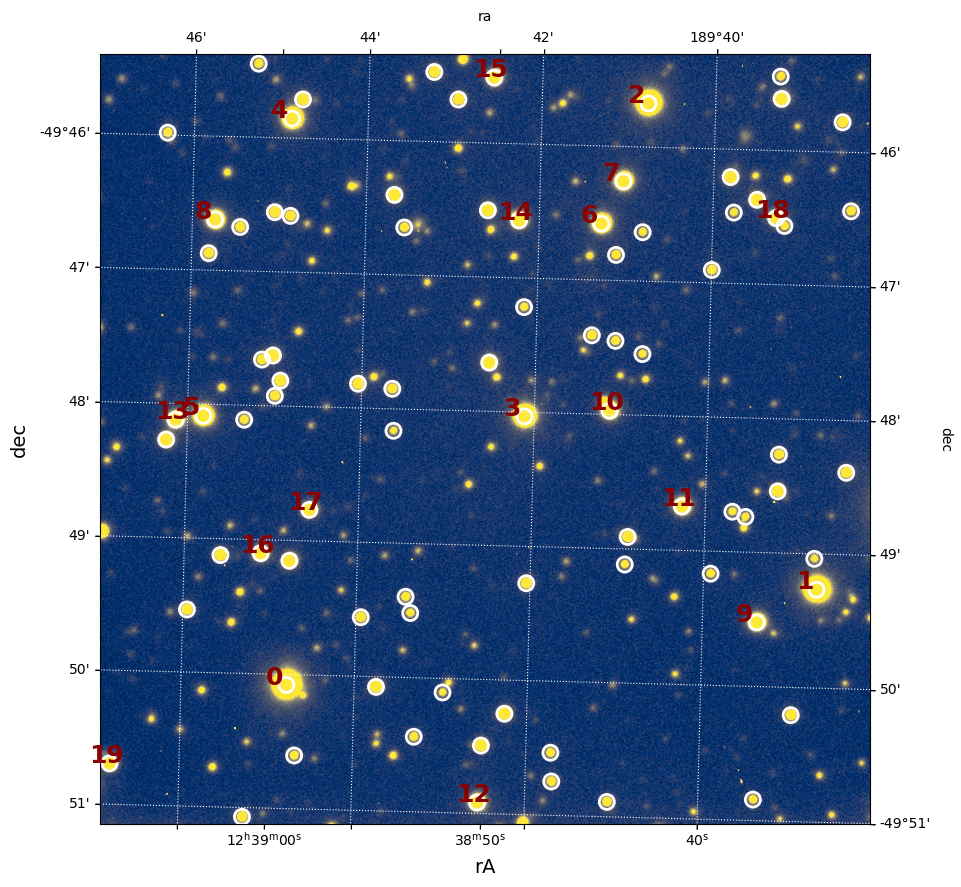

In [9]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          sci_list,
                                          reducedir,
                                          stack_suffix=stack_suffix,
                                          force=FORCE,
                                          plot=True) 

### PLOT results

The function ``s4plt.plot_sci_frame`` can be used to plot ``proc.fits`` or ``stack.fits`` products, as in the example below.  

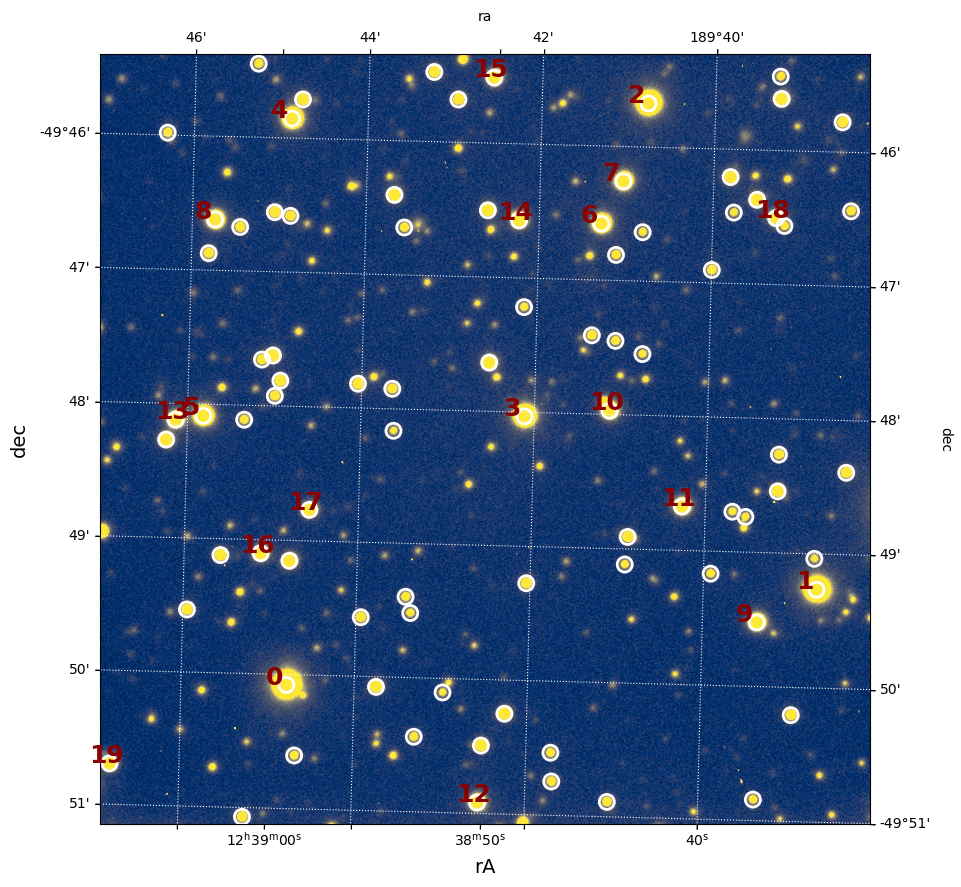

In [10]:
s4plt.plot_sci_frame(p['OBJECT_STACK'], cat_ext=3, nstars=20, use_sky_coords=True)

## Time series of `PHOTOMETRY` data : `light curve`

In this section, we compile all photometric information from the reduced ``proc.fits`` frames into a photometric time series product (`light curve`) using the routine ``s4pipelib.phot_time_series``. For this example, since there are only a few frames, the time series is not particularly interesting, as it contains only a few points in the time series.

In [11]:
ts_suffix = "{}_s4c{}_{}".format(NIGHTDIR, CHANNEL, OBJECTID.replace(" ",""))

list_of_catalogs = s4pipelib.get_list_of_catalogs(p['PHOT_APERTURES_FOR_LIGHTCURVES'])

phot_ts_product = s4pipelib.phot_time_series(p['OBJECT_REDUCED_IMAGES'][1:],
                                             ts_suffix=ts_suffix,
                                             reduce_dir=reducedir,
                                             time_key=p['TIME_KEYWORD_IN_PROC'],
                                             time_format=p['TIME_FORMAT_IN_PROC'],
                                             catalog_names=list_of_catalogs,
                                             time_span_for_rms=p['TIME_SPAN_FOR_RMS'],
                                             force=FORCE)

The function ``s4plt.plot_light_curve`` enables access to the photometric time series product and facilitates the construction of differential photometric light curves. The results are plotted and returned as an Astropy Table, which can also be saved to an output CSV file.

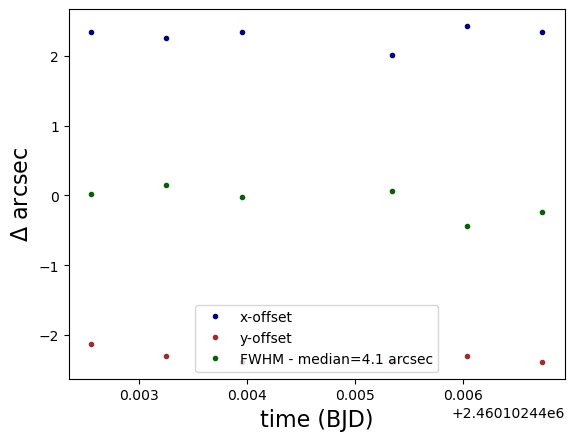

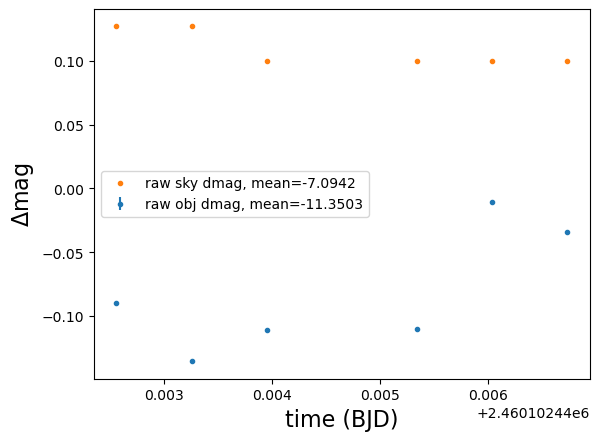

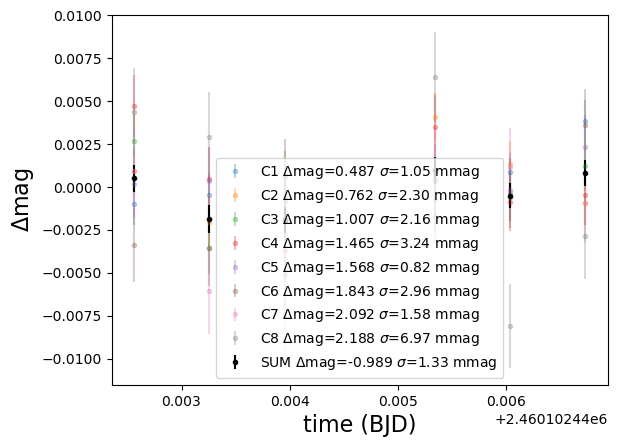

<Table length=6>
       TIME                x         ...       magsum_err            diffmagsum      
     float64            float64      ...        float64               float64        
------------------ ----------------- ... --------------------- ----------------------
 2460102.446729529 247.4874889888334 ... 0.0048316043584548446  0.0008220865866457316
 2460102.446035073 247.7374889888334 ...  0.004760806734657686 -0.0005015092298892299
 2460102.445340606 246.4874889888334 ...  0.005051490336680818  0.0009753407867156838
2460102.4425627585 247.4874889888334 ...  0.004999919949254368  0.0005015092298892299
 2460102.443951682 247.4874889888334 ...  0.005044660608696833 -0.0019263363222785657
 2460102.443257226 247.2374889888334 ...  0.005128832818607536 -0.0018745778958182413

In [12]:
# Select target index
target = 0
# Select comparisons 
comps = [1, 2, 3, 4, 5, 6, 7, 8]

# plot light curve
s4plt.plot_light_curve(phot_ts_product,
                            target=target,
                            comps=comps,
                            nsig=10,
                            plot_coords=True,
                            plot_rawmags=True,
                            plot_sum=True,
                            plot_comps=True,
                            catalog_name=p['PHOT_REF_CATALOG_NAME'])

***
## `POLARIMETRIC` mode

## Select HD111579 data

In [13]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "hd111579" # HD111579 is a polarimetric standard

# create a list of science data 
pol_list = glob.glob("{}/{}".format(datadir,"*stdpol.fits"))

# set instrument mode to "POLAR"
inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']

FORCE = False

## Reduce scientific exposures in `POLARIMETRY HALF-WAVE (L/2)` mode

To reduce scientific frames in polarimetric mode, we also use the same routine, ``s4pipelib.stack_and_reduce_sci_images``. This routine performs similar procedures as in photometric mode. Additionally, it matches and organizes the polarimetric pairs (dual beam) into two distinct catalogs. Aperture photometry is computed for several aperture sizes across all sources and for all input image frames. Finally, the resulting calibrated images and their associated photometric catalogs are saved into 'proc.fits' product FITS files.

In [14]:
# initial set up
polar_mode = p['POLARIMETRY_L2_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l2_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of half-wave files (L2)
pol_l2_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L2')

2024-09-20 11:04:21,475 root - INFO - STACK: checking image 1 of 16: i=0 20230606_s4c1_000026_stdpol.fits -> NSOURCES: 14  bkg: 506.04205132493894 meanflux: 173356.79938199703   [pipeline_lib]


2024-09-20 11:04:21,475 | INFO | STACK: checking image 1 of 16: i=0 20230606_s4c1_000026_stdpol.fits -> NSOURCES: 14  bkg: 506.04205132493894 meanflux: 173356.79938199703 


2024-09-20 11:04:22,052 root - INFO - STACK: checking image 2 of 16: i=1 20230606_s4c1_000033_stdpol.fits -> NSOURCES: 14  bkg: 505.82173760003695 meanflux: 189215.94798445402   [pipeline_lib]


2024-09-20 11:04:22,052 | INFO | STACK: checking image 2 of 16: i=1 20230606_s4c1_000033_stdpol.fits -> NSOURCES: 14  bkg: 505.82173760003695 meanflux: 189215.94798445402 


2024-09-20 11:04:22,690 root - INFO - STACK: checking image 3 of 16: i=2 20230606_s4c1_000023_stdpol.fits -> NSOURCES: 14  bkg: 505.75584467202714 meanflux: 192298.01611577728   [pipeline_lib]


2024-09-20 11:04:22,690 | INFO | STACK: checking image 3 of 16: i=2 20230606_s4c1_000023_stdpol.fits -> NSOURCES: 14  bkg: 505.75584467202714 meanflux: 192298.01611577728 


2024-09-20 11:04:23,271 root - INFO - STACK: checking image 4 of 16: i=3 20230606_s4c1_000020_stdpol.fits -> NSOURCES: 14  bkg: 505.79467831035333 meanflux: 189242.2628182115   [pipeline_lib]


2024-09-20 11:04:23,271 | INFO | STACK: checking image 4 of 16: i=3 20230606_s4c1_000020_stdpol.fits -> NSOURCES: 14  bkg: 505.79467831035333 meanflux: 189242.2628182115 


2024-09-20 11:04:24,019 root - INFO - STACK: checking image 5 of 16: i=4 20230606_s4c1_000029_stdpol.fits -> NSOURCES: 13  bkg: 506.7746637834848 meanflux: 101227.38244022567   [pipeline_lib]


2024-09-20 11:04:24,019 | INFO | STACK: checking image 5 of 16: i=4 20230606_s4c1_000029_stdpol.fits -> NSOURCES: 13  bkg: 506.7746637834848 meanflux: 101227.38244022567 


2024-09-20 11:04:24,745 root - INFO - STACK: checking image 6 of 16: i=5 20230606_s4c1_000030_stdpol.fits -> NSOURCES: 14  bkg: 507.15981446248276 meanflux: 147377.21176570441   [pipeline_lib]


2024-09-20 11:04:24,745 | INFO | STACK: checking image 6 of 16: i=5 20230606_s4c1_000030_stdpol.fits -> NSOURCES: 14  bkg: 507.15981446248276 meanflux: 147377.21176570441 


2024-09-20 11:04:25,478 root - INFO - STACK: checking image 7 of 16: i=6 20230606_s4c1_000025_stdpol.fits -> NSOURCES: 14  bkg: 507.18661390519947 meanflux: 155969.94001669515   [pipeline_lib]


2024-09-20 11:04:25,478 | INFO | STACK: checking image 7 of 16: i=6 20230606_s4c1_000025_stdpol.fits -> NSOURCES: 14  bkg: 507.18661390519947 meanflux: 155969.94001669515 


2024-09-20 11:04:26,121 root - INFO - STACK: checking image 8 of 16: i=7 20230606_s4c1_000022_stdpol.fits -> NSOURCES: 14  bkg: 505.78448131537203 meanflux: 193582.53948642648   [pipeline_lib]


2024-09-20 11:04:26,121 | INFO | STACK: checking image 8 of 16: i=7 20230606_s4c1_000022_stdpol.fits -> NSOURCES: 14  bkg: 505.78448131537203 meanflux: 193582.53948642648 


2024-09-20 11:04:26,858 root - INFO - STACK: checking image 9 of 16: i=8 20230606_s4c1_000019_stdpol.fits -> NSOURCES: 14  bkg: 505.81454197622156 meanflux: 193008.39905692515   [pipeline_lib]


2024-09-20 11:04:26,858 | INFO | STACK: checking image 9 of 16: i=8 20230606_s4c1_000019_stdpol.fits -> NSOURCES: 14  bkg: 505.81454197622156 meanflux: 193008.39905692515 


2024-09-20 11:04:27,487 root - INFO - STACK: checking image 10 of 16: i=9 20230606_s4c1_000032_stdpol.fits -> NSOURCES: 14  bkg: 507.01793208840377 meanflux: 132240.05442694123   [pipeline_lib]


2024-09-20 11:04:27,487 | INFO | STACK: checking image 10 of 16: i=9 20230606_s4c1_000032_stdpol.fits -> NSOURCES: 14  bkg: 507.01793208840377 meanflux: 132240.05442694123 


2024-09-20 11:04:28,096 root - INFO - STACK: checking image 11 of 16: i=10 20230606_s4c1_000027_stdpol.fits -> NSOURCES: 14  bkg: 507.22448735551575 meanflux: 160580.59682312584   [pipeline_lib]


2024-09-20 11:04:28,096 | INFO | STACK: checking image 11 of 16: i=10 20230606_s4c1_000027_stdpol.fits -> NSOURCES: 14  bkg: 507.22448735551575 meanflux: 160580.59682312584 


2024-09-20 11:04:28,633 root - INFO - STACK: checking image 12 of 16: i=11 20230606_s4c1_000024_stdpol.fits -> NSOURCES: 15  bkg: 505.7789090813216 meanflux: 182094.68404919372   [pipeline_lib]


2024-09-20 11:04:28,633 | INFO | STACK: checking image 12 of 16: i=11 20230606_s4c1_000024_stdpol.fits -> NSOURCES: 15  bkg: 505.7789090813216 meanflux: 182094.68404919372 


2024-09-20 11:04:29,272 root - INFO - STACK: checking image 13 of 16: i=12 20230606_s4c1_000031_stdpol.fits -> NSOURCES: 14  bkg: 507.12439159113694 meanflux: 143130.00197863678   [pipeline_lib]


2024-09-20 11:04:29,272 | INFO | STACK: checking image 13 of 16: i=12 20230606_s4c1_000031_stdpol.fits -> NSOURCES: 14  bkg: 507.12439159113694 meanflux: 143130.00197863678 


2024-09-20 11:04:29,931 root - INFO - STACK: checking image 14 of 16: i=13 20230606_s4c1_000028_stdpol.fits -> NSOURCES: 12  bkg: 507.0961685873224 meanflux: 76750.87498307345   [pipeline_lib]


2024-09-20 11:04:29,931 | INFO | STACK: checking image 14 of 16: i=13 20230606_s4c1_000028_stdpol.fits -> NSOURCES: 12  bkg: 507.0961685873224 meanflux: 76750.87498307345 


2024-09-20 11:04:30,447 root - INFO - STACK: checking image 15 of 16: i=14 20230606_s4c1_000034_stdpol.fits -> NSOURCES: 14  bkg: 505.7765463448977 meanflux: 189474.10582298337   [pipeline_lib]


2024-09-20 11:04:30,447 | INFO | STACK: checking image 15 of 16: i=14 20230606_s4c1_000034_stdpol.fits -> NSOURCES: 14  bkg: 505.7765463448977 meanflux: 189474.10582298337 


2024-09-20 11:04:31,083 root - INFO - STACK: checking image 16 of 16: i=15 20230606_s4c1_000021_stdpol.fits -> NSOURCES: 14  bkg: 505.8041235397209 meanflux: 193773.69945786693   [pipeline_lib]


2024-09-20 11:04:31,083 | INFO | STACK: checking image 16 of 16: i=15 20230606_s4c1_000021_stdpol.fits -> NSOURCES: 14  bkg: 505.8041235397209 meanflux: 193773.69945786693 


2024-09-20 11:04:31,087 root - INFO - Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000026_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:31,087 | INFO | Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000026_stdpol.fits


2024-09-20 11:04:31,106 root - INFO - OBJECT files: 10  [pipeline_lib]


2024-09-20 11:04:31,106 | INFO | OBJECT files: 10


2024-09-20 11:04:31,106 root - INFO - Loading science frames to memory ...   [pipeline_lib]


2024-09-20 11:04:31,106 | INFO | Loading science frames to memory ... 


2024-09-20 11:04:31,216 root - INFO - gain:3.37 electron / adu  [pipeline_lib]


2024-09-20 11:04:31,216 | INFO | gain:3.37 electron / adu


2024-09-20 11:04:31,216 root - INFO - Calibrating science frames (CR, gain, bias, flat) for stack ...   [pipeline_lib]


2024-09-20 11:04:31,216 | INFO | Calibrating science frames (CR, gain, bias, flat) for stack ... 


2024-09-20 11:04:31,217 root - INFO - Calibrating science frame 1 of 10 : 20230606_s4c1_000026_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:31,217 | INFO | Calibrating science frame 1 of 10 : 20230606_s4c1_000026_stdpol.fits 


2024-09-20 11:04:31,583 root - INFO - Calibrating science frame 2 of 10 : 20230606_s4c1_000034_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:31,583 | INFO | Calibrating science frame 2 of 10 : 20230606_s4c1_000034_stdpol.fits 


2024-09-20 11:04:31,943 root - INFO - Calibrating science frame 3 of 10 : 20230606_s4c1_000033_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:31,943 | INFO | Calibrating science frame 3 of 10 : 20230606_s4c1_000033_stdpol.fits 


2024-09-20 11:04:32,300 root - INFO - Calibrating science frame 4 of 10 : 20230606_s4c1_000025_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:32,300 | INFO | Calibrating science frame 4 of 10 : 20230606_s4c1_000025_stdpol.fits 


2024-09-20 11:04:32,655 root - INFO - Calibrating science frame 5 of 10 : 20230606_s4c1_000030_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:32,655 | INFO | Calibrating science frame 5 of 10 : 20230606_s4c1_000030_stdpol.fits 


2024-09-20 11:04:33,101 root - INFO - Calibrating science frame 6 of 10 : 20230606_s4c1_000021_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:33,101 | INFO | Calibrating science frame 6 of 10 : 20230606_s4c1_000021_stdpol.fits 


2024-09-20 11:04:33,636 root - INFO - Calibrating science frame 7 of 10 : 20230606_s4c1_000023_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:33,636 | INFO | Calibrating science frame 7 of 10 : 20230606_s4c1_000023_stdpol.fits 


2024-09-20 11:04:34,177 root - INFO - Calibrating science frame 8 of 10 : 20230606_s4c1_000022_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:34,177 | INFO | Calibrating science frame 8 of 10 : 20230606_s4c1_000022_stdpol.fits 


2024-09-20 11:04:34,703 root - INFO - Calibrating science frame 9 of 10 : 20230606_s4c1_000031_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:34,703 | INFO | Calibrating science frame 9 of 10 : 20230606_s4c1_000031_stdpol.fits 


2024-09-20 11:04:35,249 root - INFO - Calibrating science frame 10 of 10 : 20230606_s4c1_000032_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:35,249 | INFO | Calibrating science frame 10 of 10 : 20230606_s4c1_000032_stdpol.fits 


2024-09-20 11:04:35,807 root - INFO - Registering science frames and stacking them ...   [pipeline_lib]


2024-09-20 11:04:35,807 | INFO | Registering science frames and stacking them ... 


2024-09-20 11:04:35,809 root - INFO - Selected file for stack:0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000026_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,809 | INFO | Selected file for stack:0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000026_stdpol.fits


2024-09-20 11:04:35,813 root - INFO - Selected file for stack:1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000034_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,813 | INFO | Selected file for stack:1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000034_stdpol.fits


2024-09-20 11:04:35,817 root - INFO - Selected file for stack:2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000033_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,817 | INFO | Selected file for stack:2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000033_stdpol.fits


2024-09-20 11:04:35,822 root - INFO - Selected file for stack:3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000025_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,822 | INFO | Selected file for stack:3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000025_stdpol.fits


2024-09-20 11:04:35,827 root - INFO - Selected file for stack:4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000030_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,827 | INFO | Selected file for stack:4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000030_stdpol.fits


2024-09-20 11:04:35,830 root - INFO - Selected file for stack:5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000021_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,830 | INFO | Selected file for stack:5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000021_stdpol.fits


2024-09-20 11:04:35,836 root - INFO - Selected file for stack:6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000023_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,836 | INFO | Selected file for stack:6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000023_stdpol.fits


2024-09-20 11:04:35,839 root - INFO - Selected file for stack:7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000022_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,839 | INFO | Selected file for stack:7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000022_stdpol.fits


2024-09-20 11:04:35,841 root - INFO - Selected file for stack:8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000031_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,841 | INFO | Selected file for stack:8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000031_stdpol.fits


2024-09-20 11:04:35,847 root - INFO - Selected file for stack:9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000032_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:35,847 | INFO | Selected file for stack:9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000032_stdpol.fits


2024-09-20 11:04:35,850 astropop - INFO - Registering image 1 from 10  [register]


2024-09-20 11:04:35,850 | INFO | Registering image 1 from 10


2024-09-20 11:04:35,852 astropop - INFO - Images are equal, skipping registering.  [register]


2024-09-20 11:04:35,852 | INFO | Images are equal, skipping registering.


2024-09-20 11:04:35,972 astropop - INFO - Registering image 2 from 10  [register]


2024-09-20 11:04:35,972 | INFO | Registering image 2 from 10


2024-09-20 11:04:36,164 astropop - INFO - Filling registered image with cval=9.96  [register]


2024-09-20 11:04:36,164 | INFO | Filling registered image with cval=9.96


2024-09-20 11:04:36,177 astropop - INFO - Registering image with: translation=[1.75 0.25], rotation=0.00°  [register]


2024-09-20 11:04:36,177 | INFO | Registering image with: translation=[1.75 0.25], rotation=0.00°


2024-09-20 11:04:36,375 astropop - INFO - Registering image 3 from 10  [register]


2024-09-20 11:04:36,375 | INFO | Registering image 3 from 10


2024-09-20 11:04:36,475 astropop - INFO - Filling registered image with cval=9.97  [register]


2024-09-20 11:04:36,475 | INFO | Filling registered image with cval=9.97


2024-09-20 11:04:36,481 astropop - INFO - Registering image with: translation=[ 2.   -0.25], rotation=0.00°  [register]


2024-09-20 11:04:36,481 | INFO | Registering image with: translation=[ 2.   -0.25], rotation=0.00°


2024-09-20 11:04:36,690 astropop - INFO - Registering image 4 from 10  [register]


2024-09-20 11:04:36,690 | INFO | Registering image 4 from 10


2024-09-20 11:04:36,815 astropop - INFO - Filling registered image with cval=10.37  [register]


2024-09-20 11:04:36,815 | INFO | Filling registered image with cval=10.37


2024-09-20 11:04:36,823 astropop - INFO - Registering image with: translation=[1.25 0.75], rotation=0.00°  [register]


2024-09-20 11:04:36,823 | INFO | Registering image with: translation=[1.25 0.75], rotation=0.00°


2024-09-20 11:04:37,032 astropop - INFO - Registering image 5 from 10  [register]


2024-09-20 11:04:37,032 | INFO | Registering image 5 from 10


2024-09-20 11:04:37,128 astropop - INFO - Filling registered image with cval=10.55  [register]


2024-09-20 11:04:37,128 | INFO | Filling registered image with cval=10.55


2024-09-20 11:04:37,143 astropop - INFO - Registering image with: translation=[1.25 0.25], rotation=0.00°  [register]


2024-09-20 11:04:37,143 | INFO | Registering image with: translation=[1.25 0.25], rotation=0.00°


2024-09-20 11:04:37,366 astropop - INFO - Registering image 6 from 10  [register]


2024-09-20 11:04:37,366 | INFO | Registering image 6 from 10


2024-09-20 11:04:37,488 astropop - INFO - Filling registered image with cval=9.82  [register]


2024-09-20 11:04:37,488 | INFO | Filling registered image with cval=9.82


2024-09-20 11:04:37,499 astropop - INFO - Registering image with: translation=[1.25 1.25], rotation=0.00°  [register]


2024-09-20 11:04:37,499 | INFO | Registering image with: translation=[1.25 1.25], rotation=0.00°


2024-09-20 11:04:37,642 astropop - INFO - Registering image 7 from 10  [register]


2024-09-20 11:04:37,642 | INFO | Registering image 7 from 10


2024-09-20 11:04:37,744 astropop - INFO - Filling registered image with cval=9.87  [register]


2024-09-20 11:04:37,744 | INFO | Filling registered image with cval=9.87


2024-09-20 11:04:37,754 astropop - INFO - Registering image with: translation=[0.75 1.  ], rotation=0.00°  [register]


2024-09-20 11:04:37,754 | INFO | Registering image with: translation=[0.75 1.  ], rotation=0.00°


2024-09-20 11:04:37,878 astropop - INFO - Registering image 8 from 10  [register]


2024-09-20 11:04:37,878 | INFO | Registering image 8 from 10


2024-09-20 11:04:37,976 astropop - INFO - Filling registered image with cval=9.85  [register]


2024-09-20 11:04:37,976 | INFO | Filling registered image with cval=9.85


2024-09-20 11:04:37,994 astropop - INFO - Registering image with: translation=[1.5  1.25], rotation=0.00°  [register]


2024-09-20 11:04:37,994 | INFO | Registering image with: translation=[1.5  1.25], rotation=0.00°


2024-09-20 11:04:38,114 astropop - INFO - Registering image 9 from 10  [register]


2024-09-20 11:04:38,114 | INFO | Registering image 9 from 10


2024-09-20 11:04:38,214 astropop - INFO - Filling registered image with cval=10.57  [register]


2024-09-20 11:04:38,214 | INFO | Filling registered image with cval=10.57


2024-09-20 11:04:38,228 astropop - INFO - Registering image with: translation=[ 0.5  -0.25], rotation=0.00°  [register]


2024-09-20 11:04:38,228 | INFO | Registering image with: translation=[ 0.5  -0.25], rotation=0.00°


2024-09-20 11:04:38,382 astropop - INFO - Registering image 10 from 10  [register]


2024-09-20 11:04:38,382 | INFO | Registering image 10 from 10


2024-09-20 11:04:38,491 astropop - INFO - Filling registered image with cval=10.82  [register]


2024-09-20 11:04:38,491 | INFO | Filling registered image with cval=10.82


2024-09-20 11:04:38,507 astropop - INFO - Registering image with: translation=[ 1.75 -0.5 ], rotation=0.00°  [register]


2024-09-20 11:04:38,507 | INFO | Registering image with: translation=[ 1.75 -0.5 ], rotation=0.00°


2024-09-20 11:04:38,740 astropop - INFO - Combining 10 images with mean method.  [imcombine]


2024-09-20 11:04:38,740 | INFO | Combining 10 images with mean method.


2024-09-20 11:04:40,342 root - INFO - Creating new catalog of detected sources:  [pipeline_lib]


2024-09-20 11:04:40,342 | INFO | Creating new catalog of detected sources:


2024-09-20 11:04:40,387 root - INFO - Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()  [pipeline_lib]


2024-09-20 11:04:40,387 | INFO | Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()


2024-09-20 11:04:40,387 root - INFO - No sky coordinates given, searching sources in online catalogs  [pipeline_lib]


2024-09-20 11:04:40,387 | INFO | No sky coordinates given, searching sources in online catalogs


2024-09-20 11:04:40,388 root - INFO - Querying Gaia DR3 using twirl  [pipeline_lib]


2024-09-20 11:04:40,388 | INFO | Querying Gaia DR3 using twirl


2024-09-20 11:04:41,772 root - INFO - Matching sources with catalog and solving astrometry to compute WCS  [pipeline_lib]


2024-09-20 11:04:41,772 | INFO | Matching sources with catalog and solving astrometry to compute WCS


2024-09-20 11:04:41,913 root - WARNING - Could not solve astrometry : List of matching triangles exhausted before an acceptable transformation was found  [pipeline_lib]


2024-09-20 11:04:41,913 | WARNING | Could not solve astrometry : List of matching triangles exhausted before an acceptable transformation was found


2024-09-20 11:04:41,917 root - INFO - Running photometry for multiple apertures:  [pipeline_lib]


2024-09-20 11:04:41,917 | INFO | Running photometry for multiple apertures:


2024-09-20 11:04:41,917 root - INFO - Aperture radius of 5 pixels: 1 of 7 :  [pipeline_lib]


2024-09-20 11:04:41,917 | INFO | Aperture radius of 5 pixels: 1 of 7 :


2024-09-20 11:04:41,961 root - INFO - Aperture radius of 8 pixels: 2 of 7 :  [pipeline_lib]


2024-09-20 11:04:41,961 | INFO | Aperture radius of 8 pixels: 2 of 7 :


2024-09-20 11:04:42,005 root - INFO - Aperture radius of 10 pixels: 3 of 7 :  [pipeline_lib]


2024-09-20 11:04:42,005 | INFO | Aperture radius of 10 pixels: 3 of 7 :


2024-09-20 11:04:42,047 root - INFO - Aperture radius of 12 pixels: 4 of 7 :  [pipeline_lib]


2024-09-20 11:04:42,047 | INFO | Aperture radius of 12 pixels: 4 of 7 :


2024-09-20 11:04:42,090 root - INFO - Aperture radius of 15 pixels: 5 of 7 :  [pipeline_lib]


2024-09-20 11:04:42,090 | INFO | Aperture radius of 15 pixels: 5 of 7 :


2024-09-20 11:04:42,133 root - INFO - Aperture radius of 20 pixels: 6 of 7 :  [pipeline_lib]


2024-09-20 11:04:42,133 | INFO | Aperture radius of 20 pixels: 6 of 7 :


2024-09-20 11:04:42,181 root - INFO - Aperture radius of 25 pixels: 7 of 7 :  [pipeline_lib]


2024-09-20 11:04:42,181 | INFO | Aperture radius of 25 pixels: 7 of 7 :


2024-09-20 11:04:42,688 root - INFO - The 16 images will be reduced in 1 loops of 100 images each time  [pipeline_lib]


2024-09-20 11:04:42,688 | INFO | The 16 images will be reduced in 1 loops of 100 images each time


2024-09-20 11:04:42,689 root - INFO - Running loop 0 of 1 -> images in loop: 0 to 16 ...   [pipeline_lib]


2024-09-20 11:04:42,689 | INFO | Running loop 0 of 1 -> images in loop: 0 to 16 ... 


2024-09-20 11:04:42,817 root - INFO - OBJECT files: 17  [pipeline_lib]


2024-09-20 11:04:42,817 | INFO | OBJECT files: 17


2024-09-20 11:04:42,817 root - INFO - Creating output list of processed science frames ...   [pipeline_lib]


2024-09-20 11:04:42,817 | INFO | Creating output list of processed science frames ... 


2024-09-20 11:04:42,818 root - INFO - 1 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000026_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,818 | INFO | 1 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000026_stdpol_proc.fits


2024-09-20 11:04:42,818 root - INFO - 2 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000026_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,818 | INFO | 2 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000026_stdpol_proc.fits


2024-09-20 11:04:42,819 root - INFO - 3 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000033_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,819 | INFO | 3 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000033_stdpol_proc.fits


2024-09-20 11:04:42,819 root - INFO - 4 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000023_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,819 | INFO | 4 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000023_stdpol_proc.fits


2024-09-20 11:04:42,820 root - INFO - 5 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000020_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,820 | INFO | 5 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000020_stdpol_proc.fits


2024-09-20 11:04:42,820 root - INFO - 6 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000029_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,820 | INFO | 6 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000029_stdpol_proc.fits


2024-09-20 11:04:42,821 root - INFO - 7 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000030_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,821 | INFO | 7 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000030_stdpol_proc.fits


2024-09-20 11:04:42,821 root - INFO - 8 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000025_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,821 | INFO | 8 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000025_stdpol_proc.fits


2024-09-20 11:04:42,822 root - INFO - 9 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000022_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,822 | INFO | 9 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000022_stdpol_proc.fits


2024-09-20 11:04:42,822 root - INFO - 10 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000019_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,822 | INFO | 10 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000019_stdpol_proc.fits


2024-09-20 11:04:42,822 root - INFO - 11 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000032_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,822 | INFO | 11 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000032_stdpol_proc.fits


2024-09-20 11:04:42,823 root - INFO - 12 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000027_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,823 | INFO | 12 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000027_stdpol_proc.fits


2024-09-20 11:04:42,823 root - INFO - 13 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000024_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,823 | INFO | 13 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000024_stdpol_proc.fits


2024-09-20 11:04:42,824 root - INFO - 14 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000031_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,824 | INFO | 14 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000031_stdpol_proc.fits


2024-09-20 11:04:42,824 root - INFO - 15 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000028_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,824 | INFO | 15 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000028_stdpol_proc.fits


2024-09-20 11:04:42,825 root - INFO - 16 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000034_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,825 | INFO | 16 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000034_stdpol_proc.fits


2024-09-20 11:04:42,825 root - INFO - 17 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000021_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:04:42,825 | INFO | 17 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000021_stdpol_proc.fits


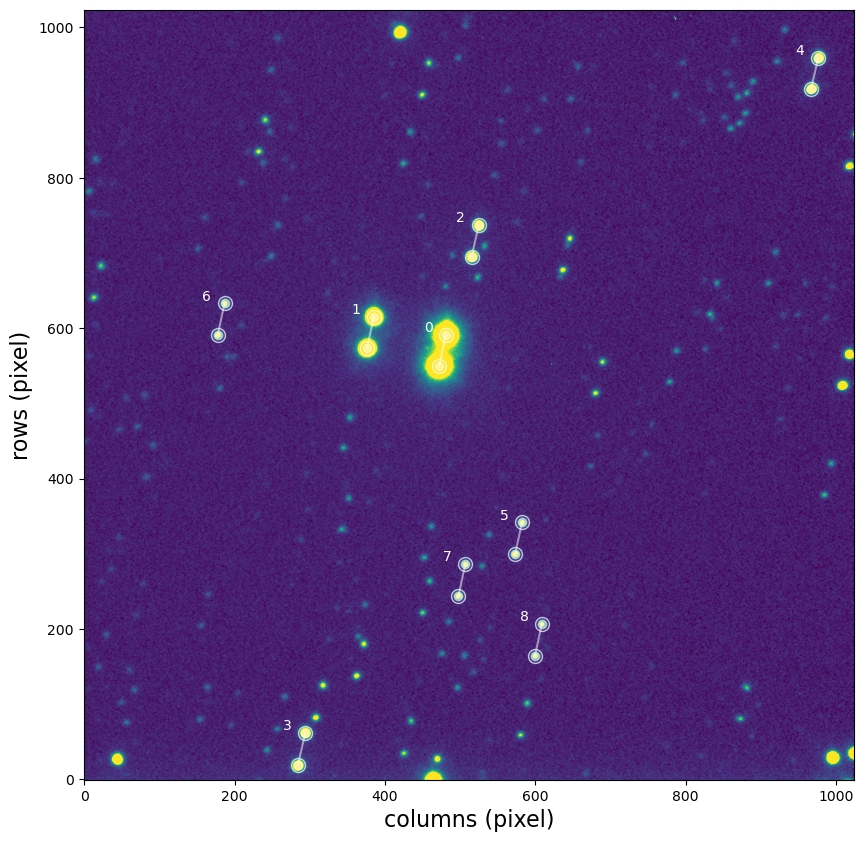

In [15]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l2_list,
                                          reducedir,
                                          stack_suffix=l2_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,
                                          plot=True) 

## Calculate `HALF-WAVE (L/2)` POLARIMETRY

The half-wave ($\lambda/2$) polarimetry is calculated using the [dual beam polarimetry method](https://astropop.readthedocs.io/en/latest/reduction/polarimetry.html). It is executed in two steps. First run the routine ``s4utils.select_polar_sequence`` to automatically identify and select polarimetric sequences from the input list of files.  Then run ``s4pipelib.compute_polarimetry`` for each sequence to obtain the corresponding polarimetric measurements. The results are save into the ``polar.fits`` product FITS file. The polarimetry results can be accessed using the routine ``s4pipelib.get_polarimetry_results``, as in the example below. 

In [16]:
# input reduced files list
red_pol_l2_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l2_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l2_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


2024-09-20 11:04:43,179 root - INFO - There is already a polarimetry product :  [pipeline_lib]


2024-09-20 11:04:43,179 | INFO | There is already a polarimetry product :


2024-09-20 11:04:43,301 root - INFO - Source index: i=0   [pipeline_lib]


2024-09-20 11:04:43,301 | INFO | Source index: i=0 


2024-09-20 11:04:43,301 root - INFO - Source RA=192.76471679879444 Dec=-61.24381607027435 mag=-17.2852+-0.0002  [pipeline_lib]


2024-09-20 11:04:43,301 | INFO | Source RA=192.76471679879444 Dec=-61.24381607027435 mag=-17.2852+-0.0002


2024-09-20 11:04:43,302 root - INFO - Best aperture radius: 20.0 pixels  [pipeline_lib]


2024-09-20 11:04:43,302 | INFO | Best aperture radius: 20.0 pixels


2024-09-20 11:04:43,302 root - INFO - Polarization in Q: 0.0234+-0.0007  [pipeline_lib]


2024-09-20 11:04:43,302 | INFO | Polarization in Q: 0.0234+-0.0007


2024-09-20 11:04:43,303 root - INFO - Polarization in U: 0.0568+-0.0007  [pipeline_lib]


2024-09-20 11:04:43,303 | INFO | Polarization in U: 0.0568+-0.0007


2024-09-20 11:04:43,303 root - INFO - Polarization in V: nan+-nan  [pipeline_lib]


2024-09-20 11:04:43,303 | INFO | Polarization in V: nan+-nan


2024-09-20 11:04:43,303 root - INFO - Total linear polarization p: 0.0614+-0.0007  [pipeline_lib]


2024-09-20 11:04:43,303 | INFO | Total linear polarization p: 0.0614+-0.0007


2024-09-20 11:04:43,304 root - INFO - Angle of polarization theta: 33.8+-0.3  [pipeline_lib]


2024-09-20 11:04:43,304 | INFO | Angle of polarization theta: 33.8+-0.3


2024-09-20 11:04:43,304 root - INFO - Free constant k: 1+-nan  [pipeline_lib]


2024-09-20 11:04:43,304 | INFO | Free constant k: 1+-nan


2024-09-20 11:04:43,305 root - INFO - Zero of polarization: 0.0+-0.0  [pipeline_lib]


2024-09-20 11:04:43,305 | INFO | Zero of polarization: 0.0+-0.0


2024-09-20 11:04:43,305 root - INFO - RMS of zi residuals: 0.0004358266550987624  [pipeline_lib]


2024-09-20 11:04:43,305 | INFO | RMS of zi residuals: 0.0004358266550987624


2024-09-20 11:04:43,305 root - INFO - Reduced chi-square (n=16.0, DOF=14.0): 9.65  [pipeline_lib]


2024-09-20 11:04:43,305 | INFO | Reduced chi-square (n=16.0, DOF=14.0): 9.65


2024-09-20 11:04:43,350 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:43,350 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:43,354 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:43,354 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:43,454 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:43,454 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:04:43,456 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:04:43,456 | INFO | Substituting symbol \perp from STIXGeneral


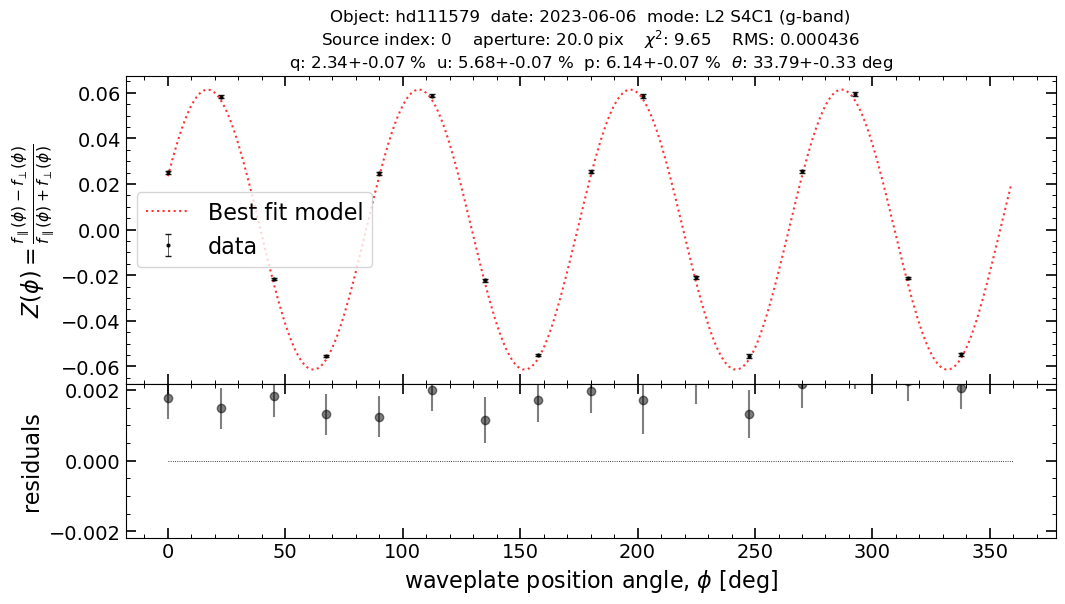

In [17]:
l2_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key = 'WPPOS',
                                                 wave_plate = 'halfwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = True,
                                                 fit_zero = False,
                                                 force = FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=20,
                                                    plot=True,
                                                    verbose=True)
    
    l2_polar_products.append(polarproduct)

## Time series of `HALF-WAVE (L/2)` polarimetry data

In this section, we compile all selected polarimetric sequences into a time series product using the routine ``s4pipelib.polar_time_series``. However, for this particular example, since there is only one polarimetric sequence, the time series is not particularly relevant, as it contains only one point in time.

In [18]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)    

PolarTimeSeriesProduct = s4pipelib.polar_time_series(l2_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

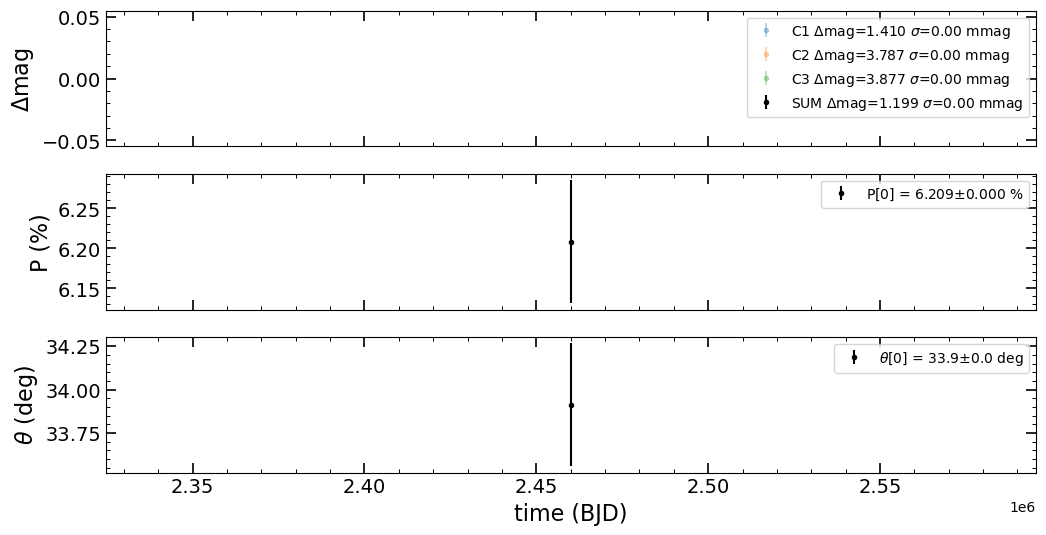

<Table length=1>
diffmag_C00000   diffmag_err_C00000   diffmag_C00001 ...   polarization_2  polarization_2_err
   float64            float64            float64     ...      float64           float64      
-------------- ---------------------- -------------- ... ----------------- ------------------
           0.0 0.00037068512823827725            0.0 ... 33.91354395986078 0.3553788121098906

In [19]:
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)

## Reduce scientific exposures in `POLARIMETRY QUARTER-WAVE (L/4)` mode

Now repeat all the reduction procedures above for the L/4 data.

In [20]:
# initial set up
polar_mode = p['POLARIMETRY_L4_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l4_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of quarter-wave files (L4)
pol_l4_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L4')

2024-09-20 11:04:44,519 root - INFO - STACK: checking image 1 of 16: i=0 20230606_s4c1_000043_stdpol.fits -> NSOURCES: 14  bkg: 507.1796564262245 meanflux: 188105.1727773729   [pipeline_lib]


2024-09-20 11:04:44,519 | INFO | STACK: checking image 1 of 16: i=0 20230606_s4c1_000043_stdpol.fits -> NSOURCES: 14  bkg: 507.1796564262245 meanflux: 188105.1727773729 


2024-09-20 11:04:45,012 root - INFO - STACK: checking image 2 of 16: i=1 20230606_s4c1_000036_stdpol.fits -> NSOURCES: 14  bkg: 506.7857204240688 meanflux: 187460.14769877907   [pipeline_lib]


2024-09-20 11:04:45,012 | INFO | STACK: checking image 2 of 16: i=1 20230606_s4c1_000036_stdpol.fits -> NSOURCES: 14  bkg: 506.7857204240688 meanflux: 187460.14769877907 


2024-09-20 11:04:45,764 root - INFO - STACK: checking image 3 of 16: i=2 20230606_s4c1_000046_stdpol.fits -> NSOURCES: 14  bkg: 507.16023333717624 meanflux: 189212.0814565981   [pipeline_lib]


2024-09-20 11:04:45,764 | INFO | STACK: checking image 3 of 16: i=2 20230606_s4c1_000046_stdpol.fits -> NSOURCES: 14  bkg: 507.16023333717624 meanflux: 189212.0814565981 


2024-09-20 11:04:46,391 root - INFO - STACK: checking image 4 of 16: i=3 20230606_s4c1_000050_stdpol.fits -> NSOURCES: 14  bkg: 507.07972362517944 meanflux: 189506.47633684397   [pipeline_lib]


2024-09-20 11:04:46,391 | INFO | STACK: checking image 4 of 16: i=3 20230606_s4c1_000050_stdpol.fits -> NSOURCES: 14  bkg: 507.07972362517944 meanflux: 189506.47633684397 


2024-09-20 11:04:46,893 root - INFO - STACK: checking image 5 of 16: i=4 20230606_s4c1_000035_stdpol.fits -> NSOURCES: 16  bkg: 506.1301902828102 meanflux: 188049.2432163432   [pipeline_lib]


2024-09-20 11:04:46,893 | INFO | STACK: checking image 5 of 16: i=4 20230606_s4c1_000035_stdpol.fits -> NSOURCES: 16  bkg: 506.1301902828102 meanflux: 188049.2432163432 


2024-09-20 11:04:47,362 root - INFO - STACK: checking image 6 of 16: i=5 20230606_s4c1_000045_stdpol.fits -> NSOURCES: 14  bkg: 507.2097471288627 meanflux: 183594.43189596548   [pipeline_lib]


2024-09-20 11:04:47,362 | INFO | STACK: checking image 6 of 16: i=5 20230606_s4c1_000045_stdpol.fits -> NSOURCES: 14  bkg: 507.2097471288627 meanflux: 183594.43189596548 


2024-09-20 11:04:47,900 root - INFO - STACK: checking image 7 of 16: i=6 20230606_s4c1_000040_stdpol.fits -> NSOURCES: 14  bkg: 507.13268621830457 meanflux: 187839.07126035402   [pipeline_lib]


2024-09-20 11:04:47,900 | INFO | STACK: checking image 7 of 16: i=6 20230606_s4c1_000040_stdpol.fits -> NSOURCES: 14  bkg: 507.13268621830457 meanflux: 187839.07126035402 


2024-09-20 11:04:48,437 root - INFO - STACK: checking image 8 of 16: i=7 20230606_s4c1_000039_stdpol.fits -> NSOURCES: 14  bkg: 507.1375913327968 meanflux: 191920.63576471256   [pipeline_lib]


2024-09-20 11:04:48,437 | INFO | STACK: checking image 8 of 16: i=7 20230606_s4c1_000039_stdpol.fits -> NSOURCES: 14  bkg: 507.1375913327968 meanflux: 191920.63576471256 


2024-09-20 11:04:49,063 root - INFO - STACK: checking image 9 of 16: i=8 20230606_s4c1_000049_stdpol.fits -> NSOURCES: 14  bkg: 507.1144828441681 meanflux: 189448.8734159907   [pipeline_lib]


2024-09-20 11:04:49,063 | INFO | STACK: checking image 9 of 16: i=8 20230606_s4c1_000049_stdpol.fits -> NSOURCES: 14  bkg: 507.1144828441681 meanflux: 189448.8734159907 


2024-09-20 11:04:49,595 root - INFO - STACK: checking image 10 of 16: i=9 20230606_s4c1_000047_stdpol.fits -> NSOURCES: 14  bkg: 507.1450583197269 meanflux: 185789.14996380283   [pipeline_lib]


2024-09-20 11:04:49,595 | INFO | STACK: checking image 10 of 16: i=9 20230606_s4c1_000047_stdpol.fits -> NSOURCES: 14  bkg: 507.1450583197269 meanflux: 185789.14996380283 


2024-09-20 11:04:50,171 root - INFO - STACK: checking image 11 of 16: i=10 20230606_s4c1_000037_stdpol.fits -> NSOURCES: 14  bkg: 507.1395496098114 meanflux: 191625.51277650992   [pipeline_lib]


2024-09-20 11:04:50,171 | INFO | STACK: checking image 11 of 16: i=10 20230606_s4c1_000037_stdpol.fits -> NSOURCES: 14  bkg: 507.1395496098114 meanflux: 191625.51277650992 


2024-09-20 11:04:50,734 root - INFO - STACK: checking image 12 of 16: i=11 20230606_s4c1_000042_stdpol.fits -> NSOURCES: 14  bkg: 507.1827007658899 meanflux: 185375.8354508027   [pipeline_lib]


2024-09-20 11:04:50,734 | INFO | STACK: checking image 12 of 16: i=11 20230606_s4c1_000042_stdpol.fits -> NSOURCES: 14  bkg: 507.1827007658899 meanflux: 185375.8354508027 


2024-09-20 11:04:51,258 root - INFO - STACK: checking image 13 of 16: i=12 20230606_s4c1_000048_stdpol.fits -> NSOURCES: 14  bkg: 507.1342547755585 meanflux: 186765.92321549117   [pipeline_lib]


2024-09-20 11:04:51,258 | INFO | STACK: checking image 13 of 16: i=12 20230606_s4c1_000048_stdpol.fits -> NSOURCES: 14  bkg: 507.1342547755585 meanflux: 186765.92321549117 


2024-09-20 11:04:51,808 root - INFO - STACK: checking image 14 of 16: i=13 20230606_s4c1_000038_stdpol.fits -> NSOURCES: 14  bkg: 507.05927235559466 meanflux: 188153.97748716758   [pipeline_lib]


2024-09-20 11:04:51,808 | INFO | STACK: checking image 14 of 16: i=13 20230606_s4c1_000038_stdpol.fits -> NSOURCES: 14  bkg: 507.05927235559466 meanflux: 188153.97748716758 


2024-09-20 11:04:52,308 root - INFO - STACK: checking image 15 of 16: i=14 20230606_s4c1_000041_stdpol.fits -> NSOURCES: 14  bkg: 507.1836875236724 meanflux: 186935.29514117082   [pipeline_lib]


2024-09-20 11:04:52,308 | INFO | STACK: checking image 15 of 16: i=14 20230606_s4c1_000041_stdpol.fits -> NSOURCES: 14  bkg: 507.1836875236724 meanflux: 186935.29514117082 


2024-09-20 11:04:52,814 root - INFO - STACK: checking image 16 of 16: i=15 20230606_s4c1_000044_stdpol.fits -> NSOURCES: 15  bkg: 507.202619519687 meanflux: 185575.62616854394   [pipeline_lib]


2024-09-20 11:04:52,814 | INFO | STACK: checking image 16 of 16: i=15 20230606_s4c1_000044_stdpol.fits -> NSOURCES: 15  bkg: 507.202619519687 meanflux: 185575.62616854394 


2024-09-20 11:04:52,817 root - INFO - Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000043_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:52,817 | INFO | Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000043_stdpol.fits


2024-09-20 11:04:52,836 root - INFO - OBJECT files: 10  [pipeline_lib]


2024-09-20 11:04:52,836 | INFO | OBJECT files: 10


2024-09-20 11:04:52,836 root - INFO - Loading science frames to memory ...   [pipeline_lib]


2024-09-20 11:04:52,836 | INFO | Loading science frames to memory ... 


2024-09-20 11:04:52,948 root - INFO - gain:3.37 electron / adu  [pipeline_lib]


2024-09-20 11:04:52,948 | INFO | gain:3.37 electron / adu


2024-09-20 11:04:52,949 root - INFO - Calibrating science frames (CR, gain, bias, flat) for stack ...   [pipeline_lib]


2024-09-20 11:04:52,949 | INFO | Calibrating science frames (CR, gain, bias, flat) for stack ... 


2024-09-20 11:04:52,949 root - INFO - Calibrating science frame 1 of 10 : 20230606_s4c1_000043_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:52,949 | INFO | Calibrating science frame 1 of 10 : 20230606_s4c1_000043_stdpol.fits 


2024-09-20 11:04:53,326 root - INFO - Calibrating science frame 2 of 10 : 20230606_s4c1_000050_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:53,326 | INFO | Calibrating science frame 2 of 10 : 20230606_s4c1_000050_stdpol.fits 


2024-09-20 11:04:53,705 root - INFO - Calibrating science frame 3 of 10 : 20230606_s4c1_000038_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:53,705 | INFO | Calibrating science frame 3 of 10 : 20230606_s4c1_000038_stdpol.fits 


2024-09-20 11:04:54,073 root - INFO - Calibrating science frame 4 of 10 : 20230606_s4c1_000047_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:54,073 | INFO | Calibrating science frame 4 of 10 : 20230606_s4c1_000047_stdpol.fits 


2024-09-20 11:04:54,440 root - INFO - Calibrating science frame 5 of 10 : 20230606_s4c1_000036_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:54,440 | INFO | Calibrating science frame 5 of 10 : 20230606_s4c1_000036_stdpol.fits 


2024-09-20 11:04:54,812 root - INFO - Calibrating science frame 6 of 10 : 20230606_s4c1_000040_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:54,812 | INFO | Calibrating science frame 6 of 10 : 20230606_s4c1_000040_stdpol.fits 


2024-09-20 11:04:55,200 root - INFO - Calibrating science frame 7 of 10 : 20230606_s4c1_000048_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:55,200 | INFO | Calibrating science frame 7 of 10 : 20230606_s4c1_000048_stdpol.fits 


2024-09-20 11:04:55,584 root - INFO - Calibrating science frame 8 of 10 : 20230606_s4c1_000044_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:55,584 | INFO | Calibrating science frame 8 of 10 : 20230606_s4c1_000044_stdpol.fits 


2024-09-20 11:04:55,960 root - INFO - Calibrating science frame 9 of 10 : 20230606_s4c1_000046_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:55,960 | INFO | Calibrating science frame 9 of 10 : 20230606_s4c1_000046_stdpol.fits 


2024-09-20 11:04:56,337 root - INFO - Calibrating science frame 10 of 10 : 20230606_s4c1_000042_stdpol.fits   [pipeline_lib]


2024-09-20 11:04:56,337 | INFO | Calibrating science frame 10 of 10 : 20230606_s4c1_000042_stdpol.fits 


2024-09-20 11:04:56,714 root - INFO - Registering science frames and stacking them ...   [pipeline_lib]


2024-09-20 11:04:56,714 | INFO | Registering science frames and stacking them ... 


2024-09-20 11:04:56,715 root - INFO - Selected file for stack:0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000043_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,715 | INFO | Selected file for stack:0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000043_stdpol.fits


2024-09-20 11:04:56,717 root - INFO - Selected file for stack:1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000050_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,717 | INFO | Selected file for stack:1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000050_stdpol.fits


2024-09-20 11:04:56,719 root - INFO - Selected file for stack:2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000038_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,719 | INFO | Selected file for stack:2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000038_stdpol.fits


2024-09-20 11:04:56,720 root - INFO - Selected file for stack:3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000047_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,720 | INFO | Selected file for stack:3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000047_stdpol.fits


2024-09-20 11:04:56,722 root - INFO - Selected file for stack:4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000036_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,722 | INFO | Selected file for stack:4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000036_stdpol.fits


2024-09-20 11:04:56,724 root - INFO - Selected file for stack:5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000040_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,724 | INFO | Selected file for stack:5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000040_stdpol.fits


2024-09-20 11:04:56,725 root - INFO - Selected file for stack:6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000048_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,725 | INFO | Selected file for stack:6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000048_stdpol.fits


2024-09-20 11:04:56,727 root - INFO - Selected file for stack:7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000044_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,727 | INFO | Selected file for stack:7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000044_stdpol.fits


2024-09-20 11:04:56,729 root - INFO - Selected file for stack:8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000046_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,729 | INFO | Selected file for stack:8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000046_stdpol.fits


2024-09-20 11:04:56,731 root - INFO - Selected file for stack:9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000042_stdpol.fits  [pipeline_lib]


2024-09-20 11:04:56,731 | INFO | Selected file for stack:9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000042_stdpol.fits


2024-09-20 11:04:56,733 astropop - INFO - Registering image 1 from 10  [register]


2024-09-20 11:04:56,733 | INFO | Registering image 1 from 10


2024-09-20 11:04:56,735 astropop - INFO - Images are equal, skipping registering.  [register]


2024-09-20 11:04:56,735 | INFO | Images are equal, skipping registering.


2024-09-20 11:04:56,846 astropop - INFO - Registering image 2 from 10  [register]


2024-09-20 11:04:56,846 | INFO | Registering image 2 from 10


2024-09-20 11:04:56,957 astropop - INFO - Filling registered image with cval=10.69  [register]


2024-09-20 11:04:56,957 | INFO | Filling registered image with cval=10.69


2024-09-20 11:04:56,968 astropop - INFO - Registering image with: translation=[-0.25  0.5 ], rotation=0.00°  [register]


2024-09-20 11:04:56,968 | INFO | Registering image with: translation=[-0.25  0.5 ], rotation=0.00°


2024-09-20 11:04:57,116 astropop - INFO - Registering image 3 from 10  [register]


2024-09-20 11:04:57,116 | INFO | Registering image 3 from 10


2024-09-20 11:04:57,210 astropop - INFO - Filling registered image with cval=10.26  [register]


2024-09-20 11:04:57,210 | INFO | Filling registered image with cval=10.26


2024-09-20 11:04:57,222 astropop - INFO - Registering image with: translation=[-0.75  1.  ], rotation=0.00°  [register]


2024-09-20 11:04:57,222 | INFO | Registering image with: translation=[-0.75  1.  ], rotation=0.00°


2024-09-20 11:04:57,394 astropop - INFO - Registering image 4 from 10  [register]


2024-09-20 11:04:57,394 | INFO | Registering image 4 from 10


2024-09-20 11:04:57,502 astropop - INFO - Filling registered image with cval=10.60  [register]


2024-09-20 11:04:57,502 | INFO | Filling registered image with cval=10.60


2024-09-20 11:04:57,515 astropop - INFO - Registering image with: translation=[-0.25  0.75], rotation=0.00°  [register]


2024-09-20 11:04:57,515 | INFO | Registering image with: translation=[-0.25  0.75], rotation=0.00°


2024-09-20 11:04:57,665 astropop - INFO - Registering image 5 from 10  [register]


2024-09-20 11:04:57,665 | INFO | Registering image 5 from 10


2024-09-20 11:04:57,773 astropop - INFO - Filling registered image with cval=10.20  [register]


2024-09-20 11:04:57,773 | INFO | Filling registered image with cval=10.20


2024-09-20 11:04:57,787 astropop - INFO - Registering image with: translation=[-0.    0.75], rotation=0.00°  [register]


2024-09-20 11:04:57,787 | INFO | Registering image with: translation=[-0.    0.75], rotation=0.00°


2024-09-20 11:04:57,938 astropop - INFO - Registering image 6 from 10  [register]


2024-09-20 11:04:57,938 | INFO | Registering image 6 from 10


2024-09-20 11:04:58,062 astropop - INFO - Filling registered image with cval=10.36  [register]


2024-09-20 11:04:58,062 | INFO | Filling registered image with cval=10.36


2024-09-20 11:04:58,075 astropop - INFO - Registering image with: translation=[-0.75 -0.  ], rotation=0.00°  [register]


2024-09-20 11:04:58,075 | INFO | Registering image with: translation=[-0.75 -0.  ], rotation=0.00°


2024-09-20 11:04:58,209 astropop - INFO - Registering image 7 from 10  [register]


2024-09-20 11:04:58,209 | INFO | Registering image 7 from 10


2024-09-20 11:04:58,307 astropop - INFO - Filling registered image with cval=10.60  [register]


2024-09-20 11:04:58,307 | INFO | Filling registered image with cval=10.60


2024-09-20 11:04:58,308 astropop - INFO - Registering image with: translation=[0.25 1.  ], rotation=0.00°  [register]


2024-09-20 11:04:58,308 | INFO | Registering image with: translation=[0.25 1.  ], rotation=0.00°


2024-09-20 11:04:58,458 astropop - INFO - Registering image 8 from 10  [register]


2024-09-20 11:04:58,458 | INFO | Registering image 8 from 10


2024-09-20 11:04:58,572 astropop - INFO - Filling registered image with cval=10.50  [register]


2024-09-20 11:04:58,572 | INFO | Filling registered image with cval=10.50


2024-09-20 11:04:58,580 astropop - INFO - Registering image with: translation=[-0.75  0.25], rotation=0.00°  [register]


2024-09-20 11:04:58,580 | INFO | Registering image with: translation=[-0.75  0.25], rotation=0.00°


2024-09-20 11:04:58,741 astropop - INFO - Registering image 9 from 10  [register]


2024-09-20 11:04:58,741 | INFO | Registering image 9 from 10


2024-09-20 11:04:58,854 astropop - INFO - Filling registered image with cval=10.56  [register]


2024-09-20 11:04:58,854 | INFO | Filling registered image with cval=10.56


2024-09-20 11:04:58,866 astropop - INFO - Registering image with: translation=[-0.    0.25], rotation=0.00°  [register]


2024-09-20 11:04:58,866 | INFO | Registering image with: translation=[-0.    0.25], rotation=0.00°


2024-09-20 11:04:59,019 astropop - INFO - Registering image 10 from 10  [register]


2024-09-20 11:04:59,019 | INFO | Registering image 10 from 10


2024-09-20 11:04:59,121 astropop - INFO - Filling registered image with cval=10.41  [register]


2024-09-20 11:04:59,121 | INFO | Filling registered image with cval=10.41


2024-09-20 11:04:59,132 astropop - INFO - Registering image with: translation=[-0.25 -0.25], rotation=0.00°  [register]


2024-09-20 11:04:59,132 | INFO | Registering image with: translation=[-0.25 -0.25], rotation=0.00°


2024-09-20 11:04:59,297 astropop - INFO - Combining 10 images with mean method.  [imcombine]


2024-09-20 11:04:59,297 | INFO | Combining 10 images with mean method.


2024-09-20 11:05:00,795 root - INFO - Creating new catalog of detected sources:  [pipeline_lib]


2024-09-20 11:05:00,795 | INFO | Creating new catalog of detected sources:


2024-09-20 11:05:00,845 root - INFO - Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()  [pipeline_lib]


2024-09-20 11:05:00,845 | INFO | Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()


2024-09-20 11:05:00,845 root - INFO - No sky coordinates given, searching sources in online catalogs  [pipeline_lib]


2024-09-20 11:05:00,845 | INFO | No sky coordinates given, searching sources in online catalogs


2024-09-20 11:05:00,846 root - INFO - Querying Gaia DR3 using twirl  [pipeline_lib]


2024-09-20 11:05:00,846 | INFO | Querying Gaia DR3 using twirl


2024-09-20 11:05:03,040 root - INFO - Matching sources with catalog and solving astrometry to compute WCS  [pipeline_lib]


2024-09-20 11:05:03,040 | INFO | Matching sources with catalog and solving astrometry to compute WCS


2024-09-20 11:05:03,197 root - WARNING - Could not solve astrometry : List of matching triangles exhausted before an acceptable transformation was found  [pipeline_lib]


2024-09-20 11:05:03,197 | WARNING | Could not solve astrometry : List of matching triangles exhausted before an acceptable transformation was found


2024-09-20 11:05:03,201 root - INFO - Running photometry for multiple apertures:  [pipeline_lib]


2024-09-20 11:05:03,201 | INFO | Running photometry for multiple apertures:


2024-09-20 11:05:03,201 root - INFO - Aperture radius of 5 pixels: 1 of 7 :  [pipeline_lib]


2024-09-20 11:05:03,201 | INFO | Aperture radius of 5 pixels: 1 of 7 :


2024-09-20 11:05:03,251 root - INFO - Aperture radius of 8 pixels: 2 of 7 :  [pipeline_lib]


2024-09-20 11:05:03,251 | INFO | Aperture radius of 8 pixels: 2 of 7 :


2024-09-20 11:05:03,300 root - INFO - Aperture radius of 10 pixels: 3 of 7 :  [pipeline_lib]


2024-09-20 11:05:03,300 | INFO | Aperture radius of 10 pixels: 3 of 7 :


2024-09-20 11:05:03,352 root - INFO - Aperture radius of 12 pixels: 4 of 7 :  [pipeline_lib]


2024-09-20 11:05:03,352 | INFO | Aperture radius of 12 pixels: 4 of 7 :


2024-09-20 11:05:03,402 root - INFO - Aperture radius of 15 pixels: 5 of 7 :  [pipeline_lib]


2024-09-20 11:05:03,402 | INFO | Aperture radius of 15 pixels: 5 of 7 :


2024-09-20 11:05:03,452 root - INFO - Aperture radius of 20 pixels: 6 of 7 :  [pipeline_lib]


2024-09-20 11:05:03,452 | INFO | Aperture radius of 20 pixels: 6 of 7 :


2024-09-20 11:05:03,501 root - INFO - Aperture radius of 25 pixels: 7 of 7 :  [pipeline_lib]


2024-09-20 11:05:03,501 | INFO | Aperture radius of 25 pixels: 7 of 7 :


2024-09-20 11:05:03,665 root - INFO - The 16 images will be reduced in 1 loops of 100 images each time  [pipeline_lib]


2024-09-20 11:05:03,665 | INFO | The 16 images will be reduced in 1 loops of 100 images each time


2024-09-20 11:05:03,666 root - INFO - Running loop 0 of 1 -> images in loop: 0 to 16 ...   [pipeline_lib]


2024-09-20 11:05:03,666 | INFO | Running loop 0 of 1 -> images in loop: 0 to 16 ... 


2024-09-20 11:05:03,795 root - INFO - OBJECT files: 17  [pipeline_lib]


2024-09-20 11:05:03,795 | INFO | OBJECT files: 17


2024-09-20 11:05:03,796 root - INFO - Creating output list of processed science frames ...   [pipeline_lib]


2024-09-20 11:05:03,796 | INFO | Creating output list of processed science frames ... 


2024-09-20 11:05:03,797 root - INFO - 1 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000043_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,797 | INFO | 1 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000043_stdpol_proc.fits


2024-09-20 11:05:03,797 root - INFO - 2 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000043_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,797 | INFO | 2 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000043_stdpol_proc.fits


2024-09-20 11:05:03,798 root - INFO - 3 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000036_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,798 | INFO | 3 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000036_stdpol_proc.fits


2024-09-20 11:05:03,798 root - INFO - 4 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000046_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,798 | INFO | 4 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000046_stdpol_proc.fits


2024-09-20 11:05:03,799 root - INFO - 5 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000050_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,799 | INFO | 5 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000050_stdpol_proc.fits


2024-09-20 11:05:03,800 root - INFO - 6 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000035_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,800 | INFO | 6 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000035_stdpol_proc.fits


2024-09-20 11:05:03,800 root - INFO - 7 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000045_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,800 | INFO | 7 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000045_stdpol_proc.fits


2024-09-20 11:05:03,801 root - INFO - 8 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000040_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,801 | INFO | 8 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000040_stdpol_proc.fits


2024-09-20 11:05:03,801 root - INFO - 9 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000039_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,801 | INFO | 9 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000039_stdpol_proc.fits


2024-09-20 11:05:03,801 root - INFO - 10 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000049_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,801 | INFO | 10 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000049_stdpol_proc.fits


2024-09-20 11:05:03,802 root - INFO - 11 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000047_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,802 | INFO | 11 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000047_stdpol_proc.fits


2024-09-20 11:05:03,802 root - INFO - 12 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000037_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,802 | INFO | 12 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000037_stdpol_proc.fits


2024-09-20 11:05:03,803 root - INFO - 13 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000042_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,803 | INFO | 13 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000042_stdpol_proc.fits


2024-09-20 11:05:03,803 root - INFO - 14 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000048_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,803 | INFO | 14 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000048_stdpol_proc.fits


2024-09-20 11:05:03,804 root - INFO - 15 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000038_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,804 | INFO | 15 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000038_stdpol_proc.fits


2024-09-20 11:05:03,804 root - INFO - 16 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000041_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,804 | INFO | 16 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000041_stdpol_proc.fits


2024-09-20 11:05:03,804 root - INFO - 17 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000044_stdpol_proc.fits  [pipeline_lib]


2024-09-20 11:05:03,804 | INFO | 17 of 17 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//20230606//sparc4acs1/20230606_s4c1_000044_stdpol_proc.fits


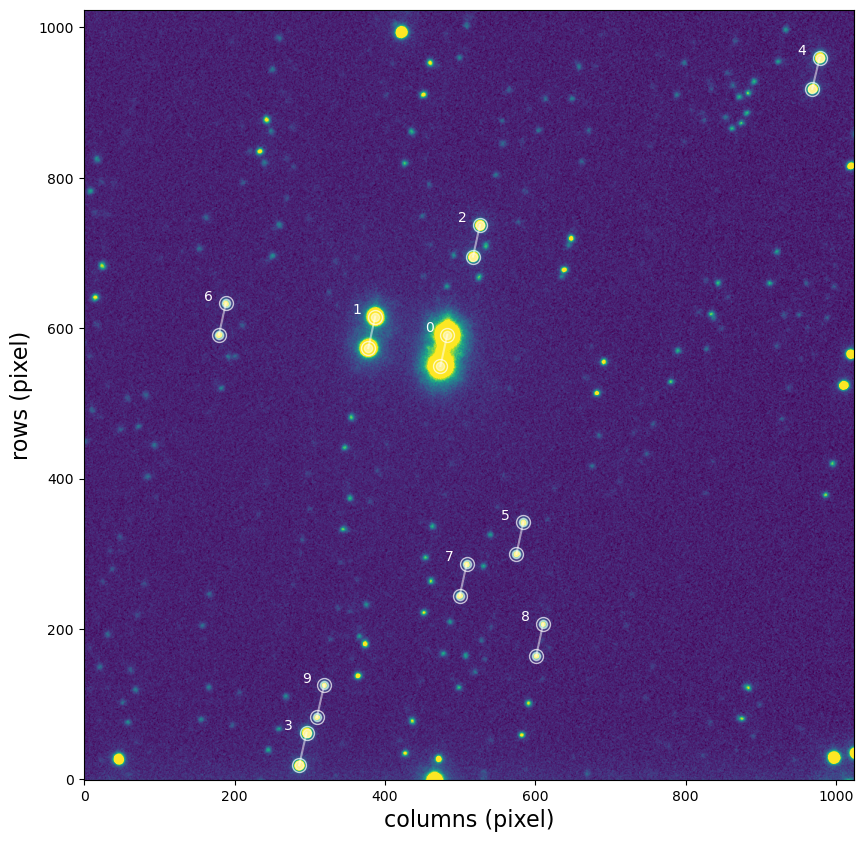

In [21]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l4_list,
                                          reducedir,
                                          stack_suffix=l4_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                              
                                          plot=True) 

## Calculate `QUARTER-WAVE (L/4)` POLARIMETRY

The quarter-wave ($\lambda/4$) polarimetry is calculated using the [dual beam polarimetry method](https://astropop.readthedocs.io/en/latest/reduction/polarimetry.html). It is executed in two steps. First run the routine ``s4utils.select_polar_sequence`` to automatically identify and select polarimetric sequences from the input list of files.  Then run ``s4pipelib.compute_polarimetry`` for each sequence to obtain the corresponding polarimetric measurements. The results are save into the ``polar.fits`` product FITS file. The polarimetry results can be accessed using the routine ``s4pipelib.get_polarimetry_results``, as in the example below. 

In [22]:
# input reduced files list
red_pol_l4_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l4_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l4_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


2024-09-20 11:05:04,160 root - INFO - There is already a polarimetry product :  [pipeline_lib]


2024-09-20 11:05:04,160 | INFO | There is already a polarimetry product :


2024-09-20 11:05:04,278 astropop - INFO - Normalization disabled.  [__init__]


2024-09-20 11:05:04,278 | INFO | Normalization disabled.


2024-09-20 11:05:04,281 root - INFO - Source index: i=0   [pipeline_lib]


2024-09-20 11:05:04,281 | INFO | Source index: i=0 


2024-09-20 11:05:04,281 root - INFO - Source RA=192.76470505172728 Dec=-61.24382058160996 mag=-17.4499+-0.0002  [pipeline_lib]


2024-09-20 11:05:04,281 | INFO | Source RA=192.76470505172728 Dec=-61.24382058160996 mag=-17.4499+-0.0002


2024-09-20 11:05:04,282 root - INFO - Best aperture radius: 20.0 pixels  [pipeline_lib]


2024-09-20 11:05:04,282 | INFO | Best aperture radius: 20.0 pixels


2024-09-20 11:05:04,282 root - INFO - Polarization in Q: -0.0273+-0.0002  [pipeline_lib]


2024-09-20 11:05:04,282 | INFO | Polarization in Q: -0.0273+-0.0002


2024-09-20 11:05:04,282 root - INFO - Polarization in U: 0.0574+-0.0004  [pipeline_lib]


2024-09-20 11:05:04,282 | INFO | Polarization in U: 0.0574+-0.0004


2024-09-20 11:05:04,283 root - INFO - Polarization in V: 0.0002+-0.0002  [pipeline_lib]


2024-09-20 11:05:04,283 | INFO | Polarization in V: 0.0002+-0.0002


2024-09-20 11:05:04,283 root - INFO - Total linear polarization p: 0.0636+-0.0003  [pipeline_lib]


2024-09-20 11:05:04,283 | INFO | Total linear polarization p: 0.0636+-0.0003


2024-09-20 11:05:04,283 root - INFO - Angle of polarization theta: 57.7+-0.2  [pipeline_lib]


2024-09-20 11:05:04,283 | INFO | Angle of polarization theta: 57.7+-0.2


2024-09-20 11:05:04,284 root - INFO - Free constant k: 1+-nan  [pipeline_lib]


2024-09-20 11:05:04,284 | INFO | Free constant k: 1+-nan


2024-09-20 11:05:04,284 root - INFO - Zero of polarization: 108.7+-0.0  [pipeline_lib]


2024-09-20 11:05:04,284 | INFO | Zero of polarization: 108.7+-0.0


2024-09-20 11:05:04,284 root - INFO - RMS of zi residuals: 0.00044621943150306763  [pipeline_lib]


2024-09-20 11:05:04,284 | INFO | RMS of zi residuals: 0.00044621943150306763


2024-09-20 11:05:04,285 root - INFO - Reduced chi-square (n=16.0, DOF=13.0): 0.76  [pipeline_lib]


2024-09-20 11:05:04,285 | INFO | Reduced chi-square (n=16.0, DOF=13.0): 0.76


2024-09-20 11:05:04,325 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:05:04,325 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:05:04,328 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:05:04,328 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:05:04,422 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:05:04,422 | INFO | Substituting symbol \perp from STIXGeneral


2024-09-20 11:05:04,425 matplotlib.mathtext - INFO - Substituting symbol \perp from STIXGeneral  [_mathtext]


2024-09-20 11:05:04,425 | INFO | Substituting symbol \perp from STIXGeneral


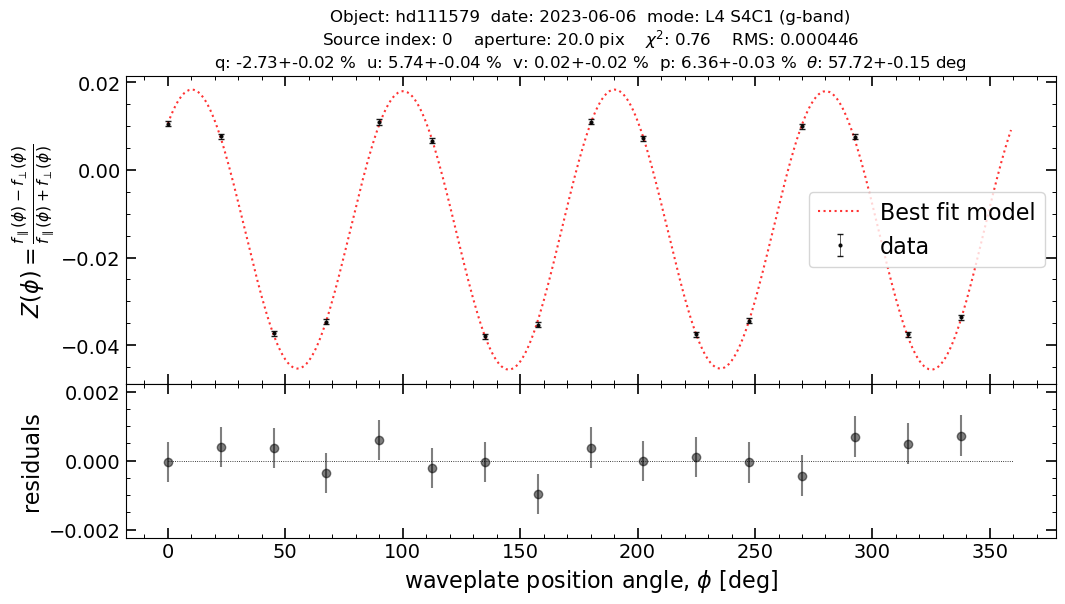

In [23]:
l4_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key='WPPOS',
                                                 wave_plate = 'quarterwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = False,
                                                 fit_zero = True,
                                                 force=FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=20,
                                                    plot=True,
                                                    verbose=True)
    l4_polar_products.append(polarproduct)    

## Time series of `QUARTER-WAVE (L/4)` polarimetry data

In [24]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)   

PolarTimeSeriesProduct = s4pipelib.polar_time_series(l4_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

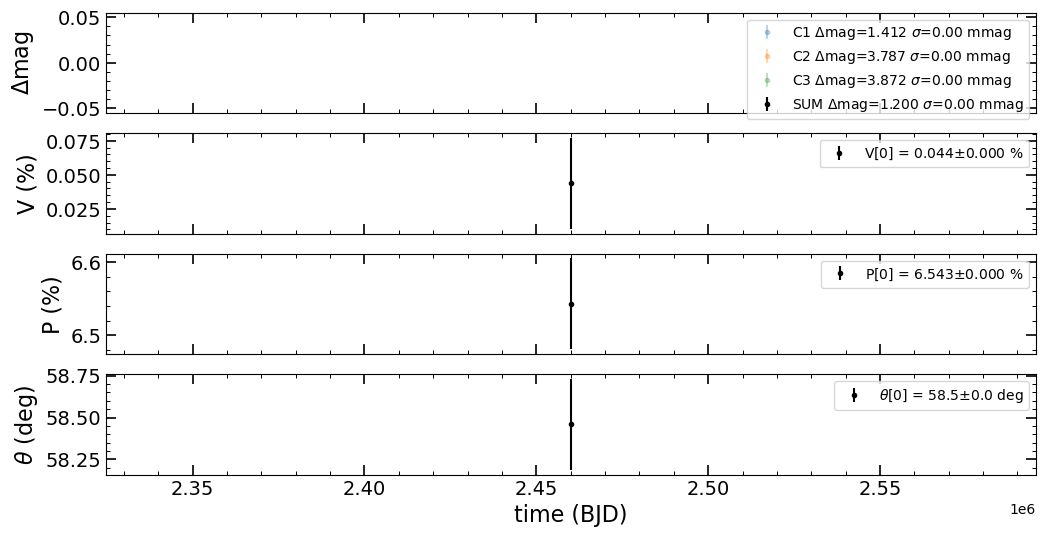

<Table length=1>
diffmag_C00000   diffmag_err_C00000   diffmag_C00001 ...   polarization_2   polarization_2_err
   float64            float64            float64     ...      float64            float64      
-------------- ---------------------- -------------- ... ----------------- -------------------
           0.0 0.00033880405584798146            0.0 ... 58.45931639927533 0.27203438951987613

In [25]:
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)